In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torchvision
from tqdm import tqdm_notebook
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import pdb

%matplotlib inline

In [14]:
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [15]:
batch_size = 20

In [16]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

class_names = tuple(str(i) for i in range(10))

In [17]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

class_names = tuple(str(i) for i in range(10))

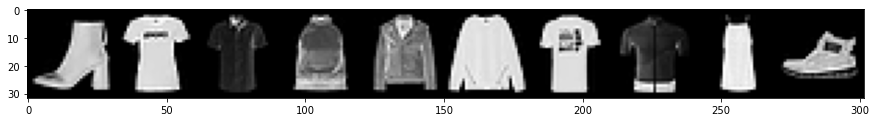

In [18]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = dataiter.next()

plt.figure(figsize=(15,10))
imshow(torchvision.utils.make_grid(images[:10], nrow=10))
plt.show()

In [19]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [20]:
device

'cuda:0'

## Simple Autoencoder

In [21]:
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
#         self.encoder = nn.Linear(784, encoding_dim)
#         self.decoder = nn.Linear(encoding_dim, 784)
        self.encoder = nn.Sequential(nn.Linear(784,392), nn.BatchNorm1d(392), nn.LeakyReLU(0.1),
                                     nn.Linear(392, 196), nn.BatchNorm1d(196), nn.LeakyReLU(0.1),
                                     nn.Linear(196, 128), nn.BatchNorm1d(128), nn.LeakyReLU(0.1),
                                     nn.Linear(128, encoding_dim))
        
        self.decoder = nn.Sequential(nn.Linear(encoding_dim, 128), nn.BatchNorm1d(128), nn.LeakyReLU(0.1),
                                     nn.Linear(128, 196), nn.BatchNorm1d(196), nn.LeakyReLU(0.1),
                                     nn.Linear(196, 392), nn.BatchNorm1d(392), nn.LeakyReLU(0.1),
                                     nn.Linear(392, 784))

    def forward(self, x):
        x = F.relu(self.encoder(x))
        x = F.sigmoid(self.decoder(x))
        return x

encoding_dim = 64
model = Autoencoder(encoding_dim)

In [22]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)

## Training

In [23]:
n_epochs = 20

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    for data in trainloader:
        images, _ = data
        images = images.view(images.size(0), -1)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*images.size(0)
            
    lr_scheduler.step()
    train_loss = train_loss/len(trainloader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))


Epoch: 1 	Training Loss: 0.482999
Epoch: 2 	Training Loss: 0.375047
Epoch: 3 	Training Loss: 0.341002
Epoch: 4 	Training Loss: 0.317932
Epoch: 5 	Training Loss: 0.303781
Epoch: 6 	Training Loss: 0.291322
Epoch: 7 	Training Loss: 0.282556
Epoch: 8 	Training Loss: 0.275304
Epoch: 9 	Training Loss: 0.267809
Epoch: 10 	Training Loss: 0.262109
Epoch: 11 	Training Loss: 0.257205
Epoch: 12 	Training Loss: 0.253040
Epoch: 13 	Training Loss: 0.249235
Epoch: 14 	Training Loss: 0.245277
Epoch: 15 	Training Loss: 0.241983
Epoch: 16 	Training Loss: 0.238833
Epoch: 17 	Training Loss: 0.236249
Epoch: 18 	Training Loss: 0.232332
Epoch: 19 	Training Loss: 0.230849
Epoch: 20 	Training Loss: 0.228356


## Testing on a random batch

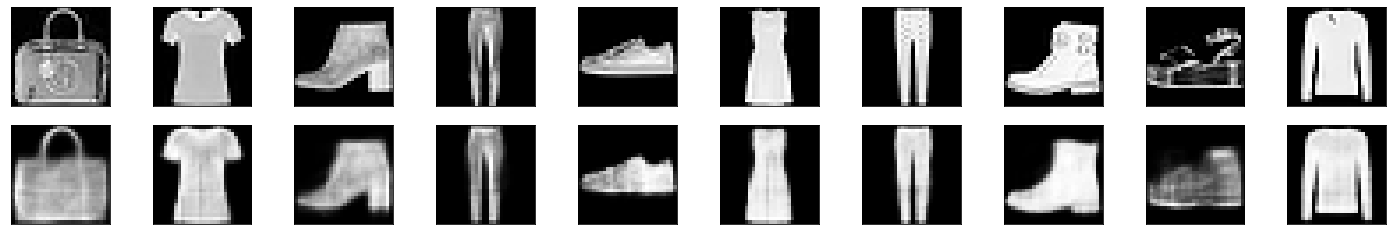

In [25]:
dataiter = iter(testloader)
images, labels = dataiter.next()

images_flatten = images.view(images.size(0), -1)
output = model(images_flatten)
images = images.numpy()

output = output.view(batch_size, 1, 28, 28)
output = output.detach().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Variational autoencoder

In [30]:
class VAE(nn.Module):
    def __init__(self, hidden_dim):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, hidden_dim)
        self.fc22 = nn.Linear(400, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        z = torch.randn_like(std)
        return mu + z*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE(20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [31]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [32]:
log_interval = 1000
from torchvision.utils import save_image

In [33]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm_notebook(trainloader)):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(trainloader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(testloader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
#                 save_image(comparison.cpu(),
#                          'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(testloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

if __name__ == "__main__":
    for epoch in range(1, 16):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       'results/sample_' + str(epoch) + '.png')

  0%|          | 0/3000 [00:00<?, ?it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 547.952930
Train Epoch: 1 [20000/60000 (33%)]	Loss: 269.579102
Train Epoch: 1 [40000/60000 (67%)]	Loss: 245.052075
====> Epoch: 1 Average loss: 263.9439
====> Test set loss: 251.8792


  0%|          | 0/3000 [00:00<?, ?it/s]

Train Epoch: 2 [0/60000 (0%)]	Loss: 238.134644
Train Epoch: 2 [20000/60000 (33%)]	Loss: 252.455884
Train Epoch: 2 [40000/60000 (67%)]	Loss: 264.305933
====> Epoch: 2 Average loss: 247.6958
====> Test set loss: 247.7386


  0%|          | 0/3000 [00:00<?, ?it/s]

Train Epoch: 3 [0/60000 (0%)]	Loss: 237.768994
Train Epoch: 3 [20000/60000 (33%)]	Loss: 289.628271
Train Epoch: 3 [40000/60000 (67%)]	Loss: 247.715869
====> Epoch: 3 Average loss: 245.1757
====> Test set loss: 246.1305


  0%|          | 0/3000 [00:00<?, ?it/s]

Train Epoch: 4 [0/60000 (0%)]	Loss: 232.540015
Train Epoch: 4 [20000/60000 (33%)]	Loss: 254.665625
Train Epoch: 4 [40000/60000 (67%)]	Loss: 244.726709
====> Epoch: 4 Average loss: 243.9622
====> Test set loss: 245.1043


  0%|          | 0/3000 [00:00<?, ?it/s]

Train Epoch: 5 [0/60000 (0%)]	Loss: 255.740796
Train Epoch: 5 [20000/60000 (33%)]	Loss: 237.404468
Train Epoch: 5 [40000/60000 (67%)]	Loss: 242.294653
====> Epoch: 5 Average loss: 243.1519
====> Test set loss: 244.8519


  0%|          | 0/3000 [00:00<?, ?it/s]

Train Epoch: 6 [0/60000 (0%)]	Loss: 248.610693
Train Epoch: 6 [20000/60000 (33%)]	Loss: 226.829712
Train Epoch: 6 [40000/60000 (67%)]	Loss: 250.076929
====> Epoch: 6 Average loss: 242.5785
====> Test set loss: 244.4312


  0%|          | 0/3000 [00:00<?, ?it/s]

Train Epoch: 7 [0/60000 (0%)]	Loss: 260.677222
Train Epoch: 7 [20000/60000 (33%)]	Loss: 214.586450
Train Epoch: 7 [40000/60000 (67%)]	Loss: 286.939380
====> Epoch: 7 Average loss: 242.1524
====> Test set loss: 243.9927


  0%|          | 0/3000 [00:00<?, ?it/s]

Train Epoch: 8 [0/60000 (0%)]	Loss: 252.544727
Train Epoch: 8 [20000/60000 (33%)]	Loss: 234.169946
Train Epoch: 8 [40000/60000 (67%)]	Loss: 239.120386
====> Epoch: 8 Average loss: 241.7905
====> Test set loss: 243.6825


  0%|          | 0/3000 [00:00<?, ?it/s]

Train Epoch: 9 [0/60000 (0%)]	Loss: 236.563013
Train Epoch: 9 [20000/60000 (33%)]	Loss: 272.639478
Train Epoch: 9 [40000/60000 (67%)]	Loss: 253.367334
====> Epoch: 9 Average loss: 241.5699
====> Test set loss: 242.9881


  0%|          | 0/3000 [00:00<?, ?it/s]

Train Epoch: 10 [0/60000 (0%)]	Loss: 240.824316
Train Epoch: 10 [20000/60000 (33%)]	Loss: 244.119287
Train Epoch: 10 [40000/60000 (67%)]	Loss: 248.062354
====> Epoch: 10 Average loss: 241.3232
====> Test set loss: 242.8124


  0%|          | 0/3000 [00:00<?, ?it/s]

Train Epoch: 11 [0/60000 (0%)]	Loss: 260.833081
Train Epoch: 11 [20000/60000 (33%)]	Loss: 249.377124
Train Epoch: 11 [40000/60000 (67%)]	Loss: 254.677197
====> Epoch: 11 Average loss: 241.0944
====> Test set loss: 242.6835


  0%|          | 0/3000 [00:00<?, ?it/s]

Train Epoch: 12 [0/60000 (0%)]	Loss: 246.903320
Train Epoch: 12 [20000/60000 (33%)]	Loss: 261.403857
Train Epoch: 12 [40000/60000 (67%)]	Loss: 227.624561
====> Epoch: 12 Average loss: 240.9196
====> Test set loss: 242.6214


  0%|          | 0/3000 [00:00<?, ?it/s]

Train Epoch: 13 [0/60000 (0%)]	Loss: 226.370410
Train Epoch: 13 [20000/60000 (33%)]	Loss: 217.036743
Train Epoch: 13 [40000/60000 (67%)]	Loss: 230.158374
====> Epoch: 13 Average loss: 240.8192
====> Test set loss: 243.2894


  0%|          | 0/3000 [00:00<?, ?it/s]

Train Epoch: 14 [0/60000 (0%)]	Loss: 218.566333
Train Epoch: 14 [20000/60000 (33%)]	Loss: 231.195166
Train Epoch: 14 [40000/60000 (67%)]	Loss: 216.924463
====> Epoch: 14 Average loss: 240.6655
====> Test set loss: 242.9433


  0%|          | 0/3000 [00:00<?, ?it/s]

Train Epoch: 15 [0/60000 (0%)]	Loss: 253.612915
Train Epoch: 15 [20000/60000 (33%)]	Loss: 252.788623
Train Epoch: 15 [40000/60000 (67%)]	Loss: 245.972852
====> Epoch: 15 Average loss: 240.5282
====> Test set loss: 242.4574
